In [1]:
from itertools import chain
import nltk
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import sklearn
import pycrfsuite

print(sklearn.__version__)

0.18.1


In [2]:
def load_file(filename):
    fp = open(filename, encoding='utf8')#,'Ur')
    data_list = []
    sent=[]
    x=0
    for line in fp:
        if (line.strip()=='.\t.\tO'):
            sent.append(tuple(line.strip().split('\t')))
            data_list.append(sent)
            sent=[]
        else:
            if(line.strip()==''):
                x=1
            else:
                sent.append(tuple(line.strip().split('\t')))
    fp.close()
    return data_list

        #print (line)
        #data_list.append(tuple(line.strip().split(',')))

In [3]:
#train_sent_smpl=load_file("D:/D drive/DataAnalytics_StudyMaterial/IIMB-BDA/ProjectZ/Iteration2/Train1Sample.csv")
#train_sent_smpl=load_file("D:/D drive/DataAnalytics_StudyMaterial/IIMB-BDA/ProjectZ/Iteration2/TrainData.csv")
train_sent_smpl=load_file("D:/D drive/DataAnalytics_StudyMaterial/IIMB-BDA/ProjectZ/Iteration3/TrainData.csv")

In [4]:
#test_sent_sampl=load_file("D:/D drive/DataAnalytics_StudyMaterial/IIMB-BDA/ProjectZ/Iteration2/Test1Sample.csv")
#test_sent_sampl=load_file("D:/D drive/DataAnalytics_StudyMaterial/IIMB-BDA/ProjectZ/Iteration2/TestData.csv")
test_sent_sampl=load_file("D:/D drive/DataAnalytics_StudyMaterial/IIMB-BDA/ProjectZ/Iteration3/TestData.csv")

In [6]:
#nltk.corpus.conll2000.fileids()

['train.txt', 'test.txt']

In [7]:
%%time
#train_sents = list(nltk.corpus.conll2000.iob_sents('train.txt'))
#test_sents = list(nltk.corpus.conll2000.iob_sents('test.txt'))

Wall time: 4.06 s


In [13]:
train_sent_smpl[1]


[('Hands', 'NNS', 'O'),
 ('on', 'IN', 'O'),
 ('experience', 'NN', 'WRKEX'),
 ('in', 'IN', 'O'),
 ('Java', 'NNP', 'SKILL'),
 ('and', 'CC', 'O'),
 ('J2EE', 'NNP', 'SKILL'),
 ('(JDBC', 'NNP', 'SKILL'),
 ('Servlet', 'NNP', 'SKILL'),
 ('JSP).', 'NNP', 'SKILL'),
 ('.', '.', 'O')]

In [36]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    features = [
        'bias',
        'word.lower=' + word.lower(),
        'word[-3:]=' + word[-3:],
        'word[-2:]=' + word[-2:],
        'word.isupper=%s' % word.isupper(),
        #'word.istitle=%s' % word.istitle(),
        'word.isdigit=%s' % word.isdigit(),
        'postag=' + postag,
        'postag[:2]=' + postag[:2],
    ]
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.extend([
            '-1:word.lower=' + word1.lower(),
            #'-1:word.istitle=%s' % word1.istitle(),
            '-1:word.isupper=%s' % word1.isupper(),
            '-1:postag=' + postag1,
            '-1:postag[:2]=' + postag1[:2],
        ])
    else:
        features.append('BOS')
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.extend([
            '+1:word.lower=' + word1.lower(),
            #'+1:word.istitle=%s' % word1.istitle(),
            '+1:word.isupper=%s' % word1.isupper(),
            '+1:postag=' + postag1,
            '+1:postag[:2]=' + postag1[:2],
        ])
    else:
        features.append('EOS')
                
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [49]:
x=sent2features(train_sent_smpl[1])
print(x)

[['bias', 'word.lower=hands', 'word[-3:]=nds', 'word[-2:]=ds', 'word.isupper=False', 'word.isdigit=False', 'postag=NNS', 'postag[:2]=NN', 'BOS', '+1:word.lower=on', '+1:word.isupper=False', '+1:postag=IN', '+1:postag[:2]=IN'], ['bias', 'word.lower=on', 'word[-3:]=on', 'word[-2:]=on', 'word.isupper=False', 'word.isdigit=False', 'postag=IN', 'postag[:2]=IN', '-1:word.lower=hands', '-1:word.isupper=False', '-1:postag=NNS', '-1:postag[:2]=NN', '+1:word.lower=experience', '+1:word.isupper=False', '+1:postag=NN', '+1:postag[:2]=NN'], ['bias', 'word.lower=experience', 'word[-3:]=nce', 'word[-2:]=ce', 'word.isupper=False', 'word.isdigit=False', 'postag=NN', 'postag[:2]=NN', '-1:word.lower=on', '-1:word.isupper=False', '-1:postag=IN', '-1:postag[:2]=IN', '+1:word.lower=in', '+1:word.isupper=False', '+1:postag=IN', '+1:postag[:2]=IN'], ['bias', 'word.lower=in', 'word[-3:]=in', 'word[-2:]=in', 'word.isupper=False', 'word.isdigit=False', 'postag=IN', 'postag[:2]=IN', '-1:word.lower=experience', '-

In [6]:
len(train_sent_smpl)

2398

In [7]:
len(test_sent_sampl)

191

In [37]:
%%time
X_train = [sent2features(s) for s in train_sent_smpl]
y_train = [sent2labels(s) for s in train_sent_smpl]

X_test = [sent2features(s) for s in test_sent_sampl]
y_test = [sent2labels(s) for s in test_sent_sampl]

Wall time: 444 ms


In [38]:
%%time
trainer = pycrfsuite.Trainer(verbose=False)

for xseq, yseq in zip(X_train, y_train):
    trainer.append(xseq, yseq)

Wall time: 858 ms


In [39]:
trainer.set_params({
    'c1': 1.0,   # coefficient for L1 penalty
    'c2': 1e-3,  # coefficient for L2 penalty
    'max_iterations': 300,  # stop earlier

    # include transitions that are possible, but not observed
    'feature.possible_transitions': True
})

In [40]:
trainer.params()

['feature.minfreq',
 'feature.possible_states',
 'feature.possible_transitions',
 'c1',
 'c2',
 'max_iterations',
 'num_memories',
 'epsilon',
 'period',
 'delta',
 'linesearch',
 'max_linesearch']

In [12]:
import os

In [13]:
os.getcwd()

'C:\\Users\\Shashank Shekar'

In [14]:
os.chdir("D:/D drive/DataAnalytics_StudyMaterial/IIMB-BDA/ProjectZ/Iteration3")

In [41]:
%%time
#trainer.train('conll2002-esp.crfsuite')
trainer.train('TotalCV5.crfsuite')

Wall time: 24.4 s


In [42]:
trainer.logparser.last_iteration

{'active_features': 3891,
 'error_norm': 74.131236,
 'feature_norm': 70.94096,
 'linesearch_step': 1.0,
 'linesearch_trials': 1,
 'loss': 10124.279483,
 'num': 300,
 'scores': {},
 'time': 0.08}

In [29]:
trainer.logparser.last_iteration

{'active_features': 3037,
 'error_norm': 54.124337,
 'feature_norm': 79.539067,
 'linesearch_step': 0.5,
 'linesearch_trials': 2,
 'loss': 10747.827798,
 'num': 919,
 'scores': {},
 'time': 0.144}

In [16]:
trainer.logparser.last_iteration

{'active_features': 3738,
 'error_norm': 73.534805,
 'feature_norm': 71.145594,
 'linesearch_step': 0.5,
 'linesearch_trials': 2,
 'loss': 10079.875607,
 'num': 500,
 'scores': {},
 'time': 0.18}

In [43]:
print (len(trainer.logparser.iterations), trainer.logparser.iterations[-1])

300 {'num': 300, 'scores': {}, 'loss': 10124.279483, 'feature_norm': 70.94096, 'error_norm': 74.131236, 'active_features': 3891, 'linesearch_trials': 1, 'linesearch_step': 1.0, 'time': 0.08}


In [44]:
tagger = pycrfsuite.Tagger()
tagger.open('TotalCV5.crfsuite')

In [45]:
example_sent = test_sent_sampl[2]
print(' '.join(sent2tokens(example_sent)), end='\n\n')

print("Predicted:", ' '.join(tagger.tag(sent2features(example_sent))))
print("Correct:  ", ' '.join(sent2labels(example_sent)))

Extensive knowledge of CoreJava concepts like OOPS Concepts Multithreading Exception Handling Interfaces Abstract Class and Collection Framework. .

Predicted: O O O O O O SKILL SKILL SKILL SKILL SKILL SKILL SKILL SKILL O SKILL SKILL O
Correct:   O O O SKILL O O SKILL SKILL SKILL SKILL SKILL SKILL SKILL SKILL SKILL SKILL SKILL O


In [33]:
def bio_classification_report(y_true, y_pred):
    """
    Classification report for a list of BIO-encoded sequences.
    It computes token-level metrics and discards "O" labels.
    
    Note that it requires scikit-learn 0.15+ (or a version from github master)
    to calculate averages properly!
    """
    lb = LabelBinarizer()
    y_true_combined = lb.fit_transform(list(chain.from_iterable(y_true)))
    y_pred_combined = lb.transform(list(chain.from_iterable(y_pred)))
        
    tagset = set(lb.classes_) - {'O'}
    tagset = sorted(tagset, key=lambda tag: tag.split('-', 1)[::-1])
    class_indices = {cls: idx for idx, cls in enumerate(lb.classes_)}
    
    return classification_report(
        y_true_combined,
        y_pred_combined,
        labels = [class_indices[cls] for cls in tagset],
        target_names = tagset,
    )

In [46]:
%%time
y_pred = [tagger.tag(xseq) for xseq in X_test]

Wall time: 67 ms


In [47]:
#more Newer Report
print(bio_classification_report(y_test, y_pred))

             precision    recall  f1-score   support

       DATE       0.94      0.74      0.83        91
      DESIG       0.81      0.68      0.74        25
        EDU       0.83      0.52      0.64        46
        LOC       0.86      0.52      0.65        46
        ORG       0.71      0.61      0.65       119
       PERS       0.82      0.56      0.67        16
      SKILL       0.85      0.66      0.74       726

avg / total       0.84      0.65      0.73      1069



In [35]:
#Newer Report
print(bio_classification_report(y_test, y_pred))

             precision    recall  f1-score   support

       DATE       0.96      0.75      0.84        91
      DESIG       0.76      0.76      0.76        25
        EDU       0.79      0.41      0.54        46
        LOC       0.84      0.46      0.59        46
        ORG       0.71      0.56      0.63       119
       PERS       0.83      0.31      0.45        16
      SKILL       0.82      0.63      0.71       726

avg / total       0.82      0.61      0.70      1069



In [22]:
#New Report
print(bio_classification_report(y_test, y_pred))

             precision    recall  f1-score   support

       DATE       0.96      0.76      0.85        91
      DESIG       0.81      0.68      0.74        25
        EDU       0.96      0.52      0.68        46
        LOC       0.89      0.54      0.68        46
        ORG       0.68      0.61      0.64       119
       PERS       0.80      0.75      0.77        16
      SKILL       0.84      0.65      0.73       726

avg / total       0.84      0.65      0.73      1069



In [12]:
# Old Report
print(bio_classification_report(y_test, y_pred))

             precision    recall  f1-score   support

       DATE       0.96      0.76      0.85        91
      DESIG       0.81      0.68      0.74        25
        EDU       0.96      0.52      0.68        46
      EMAIL       1.00      1.00      1.00         7
        LOC       0.89      0.54      0.68        46
        ORG       0.68      0.61      0.64       119
       PERS       0.87      0.81      0.84        16
      PHONE       0.80      0.80      0.80        10
      SKILL       0.84      0.65      0.73       726
      WRKEX       0.84      0.64      0.73        25

avg / total       0.84      0.65      0.73      1111



In [13]:
import seaborn as sns
import matplotlib as mplt
import matplotlib.pyplot as plt
%matplotlib inline 

In [76]:
import pandas as pd
import numpy as np
import itertools as it

In [124]:
def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.get_axes()
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))
    
def plot_classification_report(classification_report):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    title='Classification report '
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    #cmap=plt.cm.Blues
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 2)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        #print(v)
        plotMat.append(v)

    #print('plotMat: {0}'.format(plotMat))
    #print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    #yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    yticklabels = class_names
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    #plt.title(title)
    #plt.plot(np.array(plotMat))
    #plt.legend(loc = 'lower right')
    #plt.xticks=(,yticklabels)
    #plt.plot([0, 1], [0, 1],'r--')
    #plt.xlim(list(class_names))#[idx] for idx in enumerate(yticklabels)))
    #plt.ylim([0, 1])
    #plt.ylabel("Value")
    #plt.xlabel("Classes")
    #plt.show()
    heatmap(np.array(plotMat),title,xlabel, ylabel, xticklabels,yticklabels, figure_width, figure_height, correct_orientation, cmap)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\artist.py:233: MatplotlibDeprecationWarning: get_axes has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  stacklevel=1)


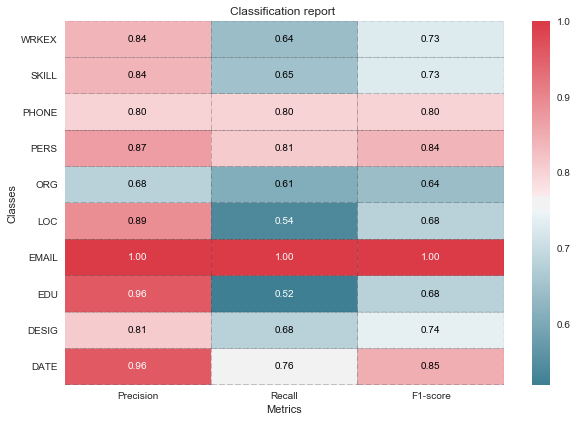

In [125]:
plot_classification_report(bio_classification_report(y_test, y_pred))

In [44]:
bio_classification_report(y_test, y_pred)

'             precision    recall  f1-score   support\n\n       DATE       0.96      0.76      0.85        91\n      DESIG       0.81      0.68      0.74        25\n        EDU       0.96      0.52      0.68        46\n      EMAIL       1.00      1.00      1.00         7\n        LOC       0.89      0.54      0.68        46\n        ORG       0.68      0.61      0.64       119\n       PERS       0.87      0.81      0.84        16\n      PHONE       0.80      0.80      0.80        10\n      SKILL       0.84      0.65      0.73       726\n      WRKEX       0.84      0.64      0.73        25\n\navg / total       0.84      0.65      0.73      1111\n'

In [48]:
from collections import Counter
info = tagger.info()

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(info.transitions).most_common(15))

print("\nTop unlikely transitions:")
print_transitions(Counter(info.transitions).most_common()[-15:])

Top likely transitions:
WRKEX  -> WRKEX   6.150599
EDU    -> EDU     5.484971
DESIG  -> DESIG   5.193139
PHONE  -> PHONE   4.815161
EMAIL  -> EMAIL   3.908476
ORG    -> ORG     3.896673
LOC    -> LOC     3.843320
EMAIL  -> PHONE   3.761063
PERS   -> PERS    3.400839
ORG    -> LOC     3.189286
SKILL  -> SKILL   3.117889
DATE   -> DATE    2.937322
PHONE  -> EMAIL   2.394929
EDU    -> ORG     2.105549
O      -> O       1.484295

Top unlikely transitions:
PHONE  -> SKILL   -1.017871
SKILL  -> DESIG   -1.118224
O      -> EMAIL   -1.168566
LOC    -> SKILL   -1.237296
SKILL  -> PHONE   -1.324623
ORG    -> SKILL   -1.337159
DATE   -> SKILL   -1.344196
PERS   -> O       -1.393979
SKILL  -> DATE    -1.466845
SKILL  -> ORG     -1.574068
EDU    -> SKILL   -1.575574
SKILL  -> PERS    -1.898789
SKILL  -> EDU     -1.979873
PERS   -> ORG     -2.160918
PERS   -> SKILL   -2.748393


In [32]:
from collections import Counter
info = tagger.info()

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(info.transitions).most_common(15))

print("\nTop unlikely transitions:")
print_transitions(Counter(info.transitions).most_common()[-15:])

Top likely transitions:
EMAIL  -> EMAIL   3.757939
EDU    -> EDU     3.633941
WRKEX  -> WRKEX   3.517239
ORG    -> ORG     3.428494
LOC    -> LOC     3.313029
DESIG  -> DESIG   3.215806
PHONE  -> PHONE   3.133305
PERS   -> PERS    2.719366
EMAIL  -> PHONE   2.564856
ORG    -> LOC     2.270312
DATE   -> DATE    2.222121
SKILL  -> SKILL   1.862740
PHONE  -> EMAIL   1.685653
O      -> O       1.564512
PERS   -> EMAIL   0.785996

Top unlikely transitions:
SKILL  -> LOC     -1.920234
DATE   -> SKILL   -1.947272
ORG    -> SKILL   -1.990016
DESIG  -> SKILL   -2.007271
SKILL  -> ORG     -2.038188
PERS   -> ORG     -2.153862
SKILL  -> DESIG   -2.230103
PHONE  -> SKILL   -2.284765
SKILL  -> PHONE   -2.444673
SKILL  -> DATE    -2.457903
WRKEX  -> SKILL   -2.528212
SKILL  -> EDU     -2.983153
SKILL  -> PERS    -3.030185
EDU    -> SKILL   -3.181291
PERS   -> SKILL   -3.211644


In [33]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-6s %s" % (weight, label, attr))    

print("Top positive:")
print_state_features(Counter(info.state_features).most_common(20))

print("\nTop negative:")
print_state_features(Counter(info.state_features).most_common()[-20:])

Top positive:
6.386089 O      word.lower=using
6.031084 DATE   -1:word.lower=till
4.836144 DATE   word.lower=may
4.832337 SKILL  word.lower=hive
4.650458 ORG    word.lower=telenet
4.328767 LOC    word.lower=bangalore
4.303009 SKILL  word.lower=jquery
4.301115 SKILL  word.lower=angular
4.290237 WRKEX  +1:word.lower=years
4.170748 SKILL  word.lower=spark
4.103823 SKILL  word.lower=wordpress
4.092707 LOC    word.lower=hyderabad
4.075117 ORG    word.lower=hospital
4.069478 SKILL  word.lower=unix
4.055064 O      EOS
3.991890 LOC    word.lower=pune
3.934869 ORG    -1:word.lower=client:
3.856411 DESIG  -1:word.lower=team
3.850966 WRKEX  +1:word.lower=year
3.816833 SKILL  word[-2:]=JS

Top negative:
-1.406615 SKILL  -1:word.lower=java
-1.407054 LOC    word[-2:]=on
-1.426566 PHONE  BOS
-1.441366 O      word.lower=dell
-1.459049 O      word.lower=certificate
-1.566300 SKILL  word.lower=experience
-1.589936 O      word.lower=manual
-1.642699 O      word[-3:]=pal
-1.749610 O      word.lower=hospit